# Exploring the Decay Position Network

This is repeating a little bit of the work that Rachel did - but going straight to a training. This notebook will use keras.

## Config

In [ ]:
func_adl_endpoint = 'http://localhost:31000'
datasets_for_training_datafile = "../data/datasets.csv"

# Constants derived in previous notebook. Need to be added to a python file of config constants.
lxyz_eta_division = 1.3
too_far_dist_lz = 7500
too_far_dist_lxy = 4400
too_short_dist_lxy=1300
too_short_dist_lz=3500

# Cuts for the jets
jet_pt_cut = 40.0
deltar_llp = 0.4

# How many events per training sample shall we train on?
training_events_per_sample = 4000
epochs_to_train = 100

# Columns to train on. This is partly gotten by looking at the `Input Variables` worksheet to remove blanks.
what_to_train_on = ['EMM_BL0', 'EMM_BL1', 'EMM_BL2',
       'EMM_BL3', 'EMM_EL0', 'EMM_EL1', 'EMM_EL2', 'EMM_EL3', 'EH_EL0',
       'EH_EL1', 'EH_EL2', 'EH_CBL0', 'EH_CBL1', 'EH_CVL2',
       'EH_TGL0', 'EH_TGL1', 'EH_TGL2', 'EH_EBL0', 'EH_EBL1', 'EH_EBL2', 'JetPt', 'JetEta']
# With an eta cut of 1.3, then EH_EL3 is also all zeros.
#  'FC_L0', 'FC_L1', 'FC_L2' - these seem to be all zeros as seen before.

## Python setup

In [2]:
# Designed not to be modified
import sys
sys.path.append("../")
from func_adl import EventDataset
from func_adl.xAOD import FuncADLServerException

from calratio_perjet_training.fetch_training_data import fetch_perjet_data
import glob
import numpy as np
import asyncio

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import rcParams
plt.rc('font', size=14)
import seaborn as sns

import pandas as pd
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

from keras.models import Sequential
from keras.layers import Dense, Dropout
import sklearn.metrics

Using TensorFlow backend.


## Load datasets

In [3]:
datasets = pd.read_csv(datasets_for_training_datafile).query('Use==1')
print(len(datasets))

57


In [4]:
async def fetch_data_async(info):
    try:
        d = await fetch_perjet_data(EventDataset(f'cacheds://{info.RucioDSName}'), f'{info.mH}_{info.mS}_{info.Lifetime}_{info.MCCampaign}', endpoint=func_adl_endpoint, jet_pt_cut=jet_pt_cut, deltar_llp=deltar_llp)
        return [info, f'{info.mH}_{info.mS}_{info.Lifetime}_{info.MCCampaign}', d]
    except FuncADLServerException as e:
        print (str(e))
        return None
all_datasets_future = [fetch_data_async(info) for index, info in datasets.iterrows()]
datasets_for_training = [f for f in (await asyncio.gather(*all_datasets_future)) if f is not None]

The request failed:
  Message: while building and running xAOD
  Log lines:
    Configured GCC from: /opt/lcg/gcc/6.2.0binutils/x86_64-slc6
    Configured AnalysisBase from: /usr/AnalysisBase/21.2.62/InstallArea/x86_64-slc6-gcc62-opt
    -- The C compiler identification is GNU 6.2.0
    -- The CXX compiler identification is GNU 6.2.0
    -- Check for working C compiler: /opt/lcg/gcc/6.2.0binutils/x86_64-slc6/bin/gcc
    -- Check for working C compiler: /opt/lcg/gcc/6.2.0binutils/x86_64-slc6/bin/gcc -- works
    -- Detecting C compiler ABI info
    -- Detecting C compiler ABI info - done
    -- Detecting C compile features
    -- Detecting C compile features - done
    -- Check for working CXX compiler: /opt/lcg/gcc/6.2.0binutils/x86_64-slc6/bin/g++
    -- Check for working CXX compiler: /opt/lcg/gcc/6.2.0binutils/x86_64-slc6/bin/g++ -- works
    -- Detecting CXX compiler ABI info
    -- Detecting CXX compiler ABI info - done
    -- Detecting CXX compile features
    -- Detecting CXX co

We need to split into training and testing sample sizes. Unfortunately, we have to do some calculations to understand if something is good signal to train on, or not. So we add a few columns here to all the datasets.

In [5]:
def add_useful_columns(ds):
    ds['Lxy'] = np.sqrt(ds.Lx*ds.Lx + ds.Ly*ds.Ly)

    ds['IsOutlier'] = False
    ds['IsOutlier'] |= ds.Lxy[ds.IsLLP & (np.abs(ds.JetEta) < lxyz_eta_division)] > too_far_dist_lxy
    ds['IsOutlier'] |= ds.Lz[ds.IsLLP & (np.abs(ds.JetEta) >= lxyz_eta_division)] > too_far_dist_lz

    ds['IsInlier'] = False
    ds['IsInlier'] |= ds.Lxy[ds.IsLLP & (np.abs(ds.JetEta) < lxyz_eta_division)] < too_short_dist_lxy
    ds['IsInlier'] |= ds.Lz[ds.IsLLP & (np.abs(ds.JetEta) >= lxyz_eta_division)] < too_short_dist_lz

    ds['JetIsCentral'] = np.abs(ds.JetEta) < lxyz_eta_division

    ds["Signal"] = ds.IsLLP & (ds.JetPt > 40) & (np.abs(ds.JetEta) < 2.4) & (ds.IsOutlier == False) & (ds.IsInlier == False) & (ds.JetIsCentral == True)

# We can limit how many datasets we combine to make life a little easier for testing with this line
what_to_combine = datasets_for_training #[20:35]
for d in what_to_combine:
    add_useful_columns(d[2])

In [6]:
all_training_jets = pd.DataFrame(pd.concat([d[2][d[2].Signal][:training_events_per_sample] for d in what_to_combine], keys=[(d[0].mH, d[0].mS, d[0].Lifetime, f'{d[0].mH}/{d[0].mS}', d[0].MCCampaign) for d in what_to_combine], names=['mH', 'mS', 'Lifetime', 'mH_mS', 'MC']).to_records())
all_testing_jets = pd.DataFrame(pd.concat([d[2][d[2].Signal][training_events_per_sample+1:] for d in what_to_combine], keys=[(d[0].mH, d[0].mS, d[0].Lifetime, f'{d[0].mH}/{d[0].mS}', d[0].MCCampaign) for d in what_to_combine], names=['mH', 'mS', 'Lifetime', 'mH_mS', 'MC']).to_records())

In [7]:
print (f'Number of training jets: {len(all_training_jets)}')
print (f'Number of testing jets: {len(all_testing_jets)}')

Number of training jets: 196000
Number of testing jets: 1867135


And quick reference for the columns we have in the data

In [8]:
all_training_jets.columns

Index(['mH', 'mS', 'Lifetime', 'mH_mS', 'MC', 'entry', 'RunNumber',
       'EventNumber', 'JetPt', 'JetEta', 'JetPhi', 'IsLLP', 'nLLPs_Near_Jets',
       'Lx', 'Ly', 'Lz', 'Leta', 'Lphi', 'Lpt', 'Lpz', 'EMM_BL0', 'EMM_BL1',
       'EMM_BL2', 'EMM_BL3', 'EMM_EL0', 'EMM_EL1', 'EMM_EL2', 'EMM_EL3',
       'EH_EL0', 'EH_EL1', 'EH_EL2', 'EH_EL3', 'EH_CBL0', 'EH_CBL1', 'EH_CVL2',
       'EH_TGL0', 'EH_TGL1', 'EH_TGL2', 'EH_EBL0', 'EH_EBL1', 'EH_EBL2',
       'FC_L0', 'FC_L1', 'FC_L2', 'Lxy', 'IsOutlier', 'IsInlier',
       'JetIsCentral', 'Signal'],
      dtype='object')

## Normalization

For this training best to center thinngs around the average before doing the training (or inference). Create some tools to do that.

In [9]:
def calc_normalization (p):
    return (p.mean(), p.std())

(input_mean, input_std) = calc_normalization(all_training_jets.filter(items=what_to_train_on))
(output_mean, output_std) = calc_normalization(all_training_jets.filter(items=['Lxy']))

def norm_inputs(p):
    return (p - input_mean) / input_std

def norm_outputs(p):
    return (p - output_mean[0]) / output_std[0]

def unnorm_outputs(p):
    return (p * output_std[0]) + output_mean[0]

In [10]:
y_train = norm_outputs(all_training_jets.Lxy)
x_train = norm_inputs(all_training_jets.filter(items=what_to_train_on))

In [11]:
x_train

EMM_BL0   EMM_BL1   EMM_BL2   EMM_BL3   EMM_EL0   EMM_EL1   EMM_EL2  \
0       2.530308  2.043549  0.506603 -0.244890 -0.084546 -0.130291 -0.135171   
1      -0.402528 -0.665218 -0.780000 -0.496200 -0.084546 -0.130291 -0.135171   
2       0.464124  1.207747  1.751238 -0.094030 -0.084546 -0.130291 -0.135171   
3      -0.508961  0.054785 -0.242774 -0.486235 -0.084546 -0.130291 -0.135171   
4      -0.429523 -0.470895  0.290415  1.136352 -0.084546 -0.130291 -0.135171   
...          ...       ...       ...       ...       ...       ...       ...   
195995 -0.536368 -0.402112 -0.691903 -0.499372 -0.084546 -0.130291 -0.135171   
195996 -0.305176 -0.460193  0.971331  2.141414 -0.084546 -0.130291 -0.135171   
195997 -0.256736 -0.312196  0.002881 -0.352208 -0.084546 -0.130291 -0.135171   
195998 -0.518385 -0.634653 -0.776133 -0.497347 -0.084546 -0.130291 -0.135171   
195999 -0.629744 -0.625607 -0.772907 -0.468331 -0.084546 -0.130291 -0.135171   

         EMM_EL3    EH_EL0  EH_EL1  ...   EH_CBL1   EH_CVL2   EH_TGL0  \
0      -0.069504 -0.042998 -0.0218  ... -0.381777 -0.320721 -0.015561   
1      -0.069504 -0.042998 -0.0218  ... -0.830948 -0.374067 -0.218545   
2      -0.069504 -0.042998 -0.0218  ... -0.818778 -0.376131  0.912579   
3      -0.069504 -0.042998 -0.0218  ... -0.827427 -0.374257 -0.073642   
4      -0.069504 -0.042998 -0.0218  ... -0.837875 -0.373898  2.442489   
...          ...       ...     ...  ...       ...       ...       ...   
195995 -0.069504 -0.042998 -0.0218  ...  2.315454 -0.325088 -0.218971   
195996 -0.069504 -0.042998 -0.0218  ... -0.195148 -0.252245 -0.254985   
195997 -0.069504 -0.042998 -0.0218  ... -0.240344 -0.315648 -0.182474   
195998 -0.069504 -0.042998 -0.0218  ...  2.019187  0.381343 -0.231747   
195999 -0.069504 -0.042998 -0.0218  ... -0.831046 -0.373856 -0.123726   

         EH_TGL1   EH_TGL2   EH_EBL0   EH_EBL1   EH_EBL2     JetPt    JetEta  
0      -0.124179  0.598331 -0.245048 -0.365801 -0.372562 -0.899407 -1.249650  
1      -0.167381 -0.365558 -0.237101  3.902989  0.968873  0.446488 -1.628851  
2       0.185779  1.306186 -0.328576 -0.184990 -0.358453 -0.885426 -1.408309  
3      -0.157575  3.212097 -0.110102  2.236601  0.171138 -0.751413  1.377600  
4      -0.042822  1.484623 -0.139040  0.707399  0.126492 -0.894019 -1.396403  
...          ...       ...       ...       ...       ...       ...       ...  
195995 -0.196338 -0.365515 -0.260061 -0.374959 -0.375098 -0.200362 -0.489898  
195996 -0.162040 -0.185748 -0.252942 -0.310390 -0.372209  0.062139 -1.348897  
195997 -0.155207  0.153244 -0.031515 -0.332624 -0.368605  2.974309 -1.245035  
195998 -0.157163 -0.388273 -0.260061 -0.376568 -0.367521  1.025224  0.750202  
195999 -0.141837 -0.387159 -0.255575 -0.362430  4.045412  0.579435  1.359856  

[196000 rows x 22 columns]

## Build the Model

In [12]:
%%capture --no-stdout --no-display

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=len(x_train.columns)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
# THis is the number of outputs - so could be 2 if we wanted to train both lxy and lz
# Activation might be softmax if we had more than one thing as we would would want it to some to some number.
# But since this is regression, we do not.
model.add(Dense(1))

#categorical_crossentropy
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=32, epochs=epochs_to_train, validation_split=0.25, shuffle=True);

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 147000 samples, validate on 49000 samples
Epoch 1/100
147000/147000 [==============================] - 17s 114us/step - loss: 0.1494 - val_loss: 0.1548
Epoch 2/100
147000/147000 [==============================] - 13s 88us/step - loss: 0.0980 - val_loss: 0.1290
Epoch 3/100
147000/147000 [==============================] - 15s 100us/step - loss: 0.0907 - val_loss: 0.1266
Epoch 4/100
147000/147000 [==============================] - 12s 82us/step - loss: 0.0870 - val_loss: 0.1288
Epoch 5/100
147000/147000 [==============================] - 26s 176us/step - loss: 0.0853 - val_loss: 0.1261
Epoch 6/100
147000/147000 [==============================] - 32s 221us/step - loss: 0.0842 - val_loss: 0.1323
Epoch 7/100
147000/147000 [==============================] - 36s 243us/step - loss: 0.0836 - val_loss: 0.1217
Epoch 8/100
147000/147000 [==============================] - 34s 234us/step - loss: 0.0831 - val_loss: 0.1260
Epoch 9/100
147000/147000 [==============================] - 37s 250us/

## Predict

This is a little tricky in the sense we want to run the prediction for the whole table. We split out the testing stuff above. So normalize it and we are ready to go!
Note we have to un-normalize things before we get to plotting and comparing!

In [13]:
x_test = norm_inputs(all_testing_jets.filter(items=what_to_train_on))

In [14]:
y_predict = model.predict(x_test)

In [15]:
all_testing_jets['p_Lxy'] = np.array(unnorm_outputs(y_predict[:,0]))

## Comparisons

Lets look at how well the prediction does vs various things

In [16]:
all_testing_jets

mH   mS  Lifetime     mH_mS     MC    entry  RunNumber  \
0          60    5         5      60/5  mc16d    21129   300000.0   
1          60    5         5      60/5  mc16d    21133   300000.0   
2          60    5         5      60/5  mc16d    21135   300000.0   
3          60    5         5      60/5  mc16d    21140   300000.0   
4          60    5         5      60/5  mc16d    21141   300000.0   
...       ...  ...       ...       ...    ...      ...        ...   
1867130  1000  475         5  1000/475  mc16d  1292407   300000.0   
1867131  1000  475         5  1000/475  mc16d  1292426   300000.0   
1867132  1000  475         5  1000/475  mc16d  1292456   300000.0   
1867133  1000  475         5  1000/475  mc16d  1292472   300000.0   
1867134  1000  475         5  1000/475  mc16d  1292496   300000.0   

         EventNumber       JetPt    JetEta  ...   EH_EBL2  FC_L0  FC_L1  \
0          2275737.0   47.878523  0.298509  ...  0.000000    0.0    0.0   
1          2275407.0   55.297469 -0.582150  ...  0.000000    0.0    0.0   
2          2275622.0   41.404203  0.907577  ...  0.000975    0.0    0.0   
3          2275251.0   48.375328  1.216177  ...  0.013956    0.0    0.0   
4          2275856.0  118.909852 -1.118637  ...  0.025431    0.0    0.0   
...              ...         ...       ...  ...       ...    ...    ...   
1867130    2319239.0  486.139094 -0.999604  ...  0.927401    0.0    0.0   
1867131    2318330.0  311.465719  1.196565  ...  0.032132    0.0    0.0   
1867132    2318668.0   83.050086  1.234407  ...  0.861817    0.0    0.0   
1867133    2318436.0  185.695859  0.580771  ...  0.000000    0.0    0.0   
1867134    2318616.0  165.751984  0.961440  ...  0.142465    0.0    0.0   

         FC_L2          Lxy  IsOutlier  IsInlier  JetIsCentral  Signal  \
0          0.0  2008.589793      False     False          True    True   
1          0.0  2471.272029      False     False          True    True   
2          0.0  1402.070343      False     False          True    True   
3          0.0  1960.130434      False     False          True    True   
4          0.0  2155.563055      False     False          True    True   
...        ...          ...        ...       ...           ...     ...   
1867130    0.0  3226.657370      False     False          True    True   
1867131    0.0  2595.336305      False     False          True    True   
1867132    0.0  3680.509720      False     False          True    True   
1867133    0.0  1929.332684      False     False          True    True   
1867134    0.0  2955.079448      False     False          True    True   

               p_Lxy  
0        2114.838379  
1        2396.012451  
2        1601.595459  
3        2061.460449  
4        2318.009277  
...              ...  
1867130  3057.928955  
1867131  2532.535889  
1867132  3416.604492  
1867133  1823.874146  
1867134  2739.717041  

[1867135 rows x 50 columns]

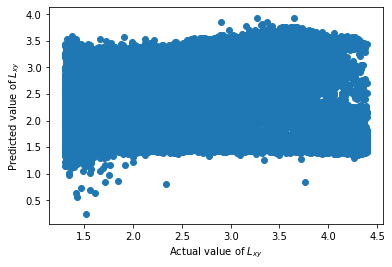

In [17]:
plt.scatter(x=all_testing_jets.Lxy/1000.0, y=all_testing_jets.p_Lxy/1000.0)
plt.xlabel('Actual value of $L_{xy}$')
plt.ylabel('Predicted value of $L_{xy}$')
plt.show()

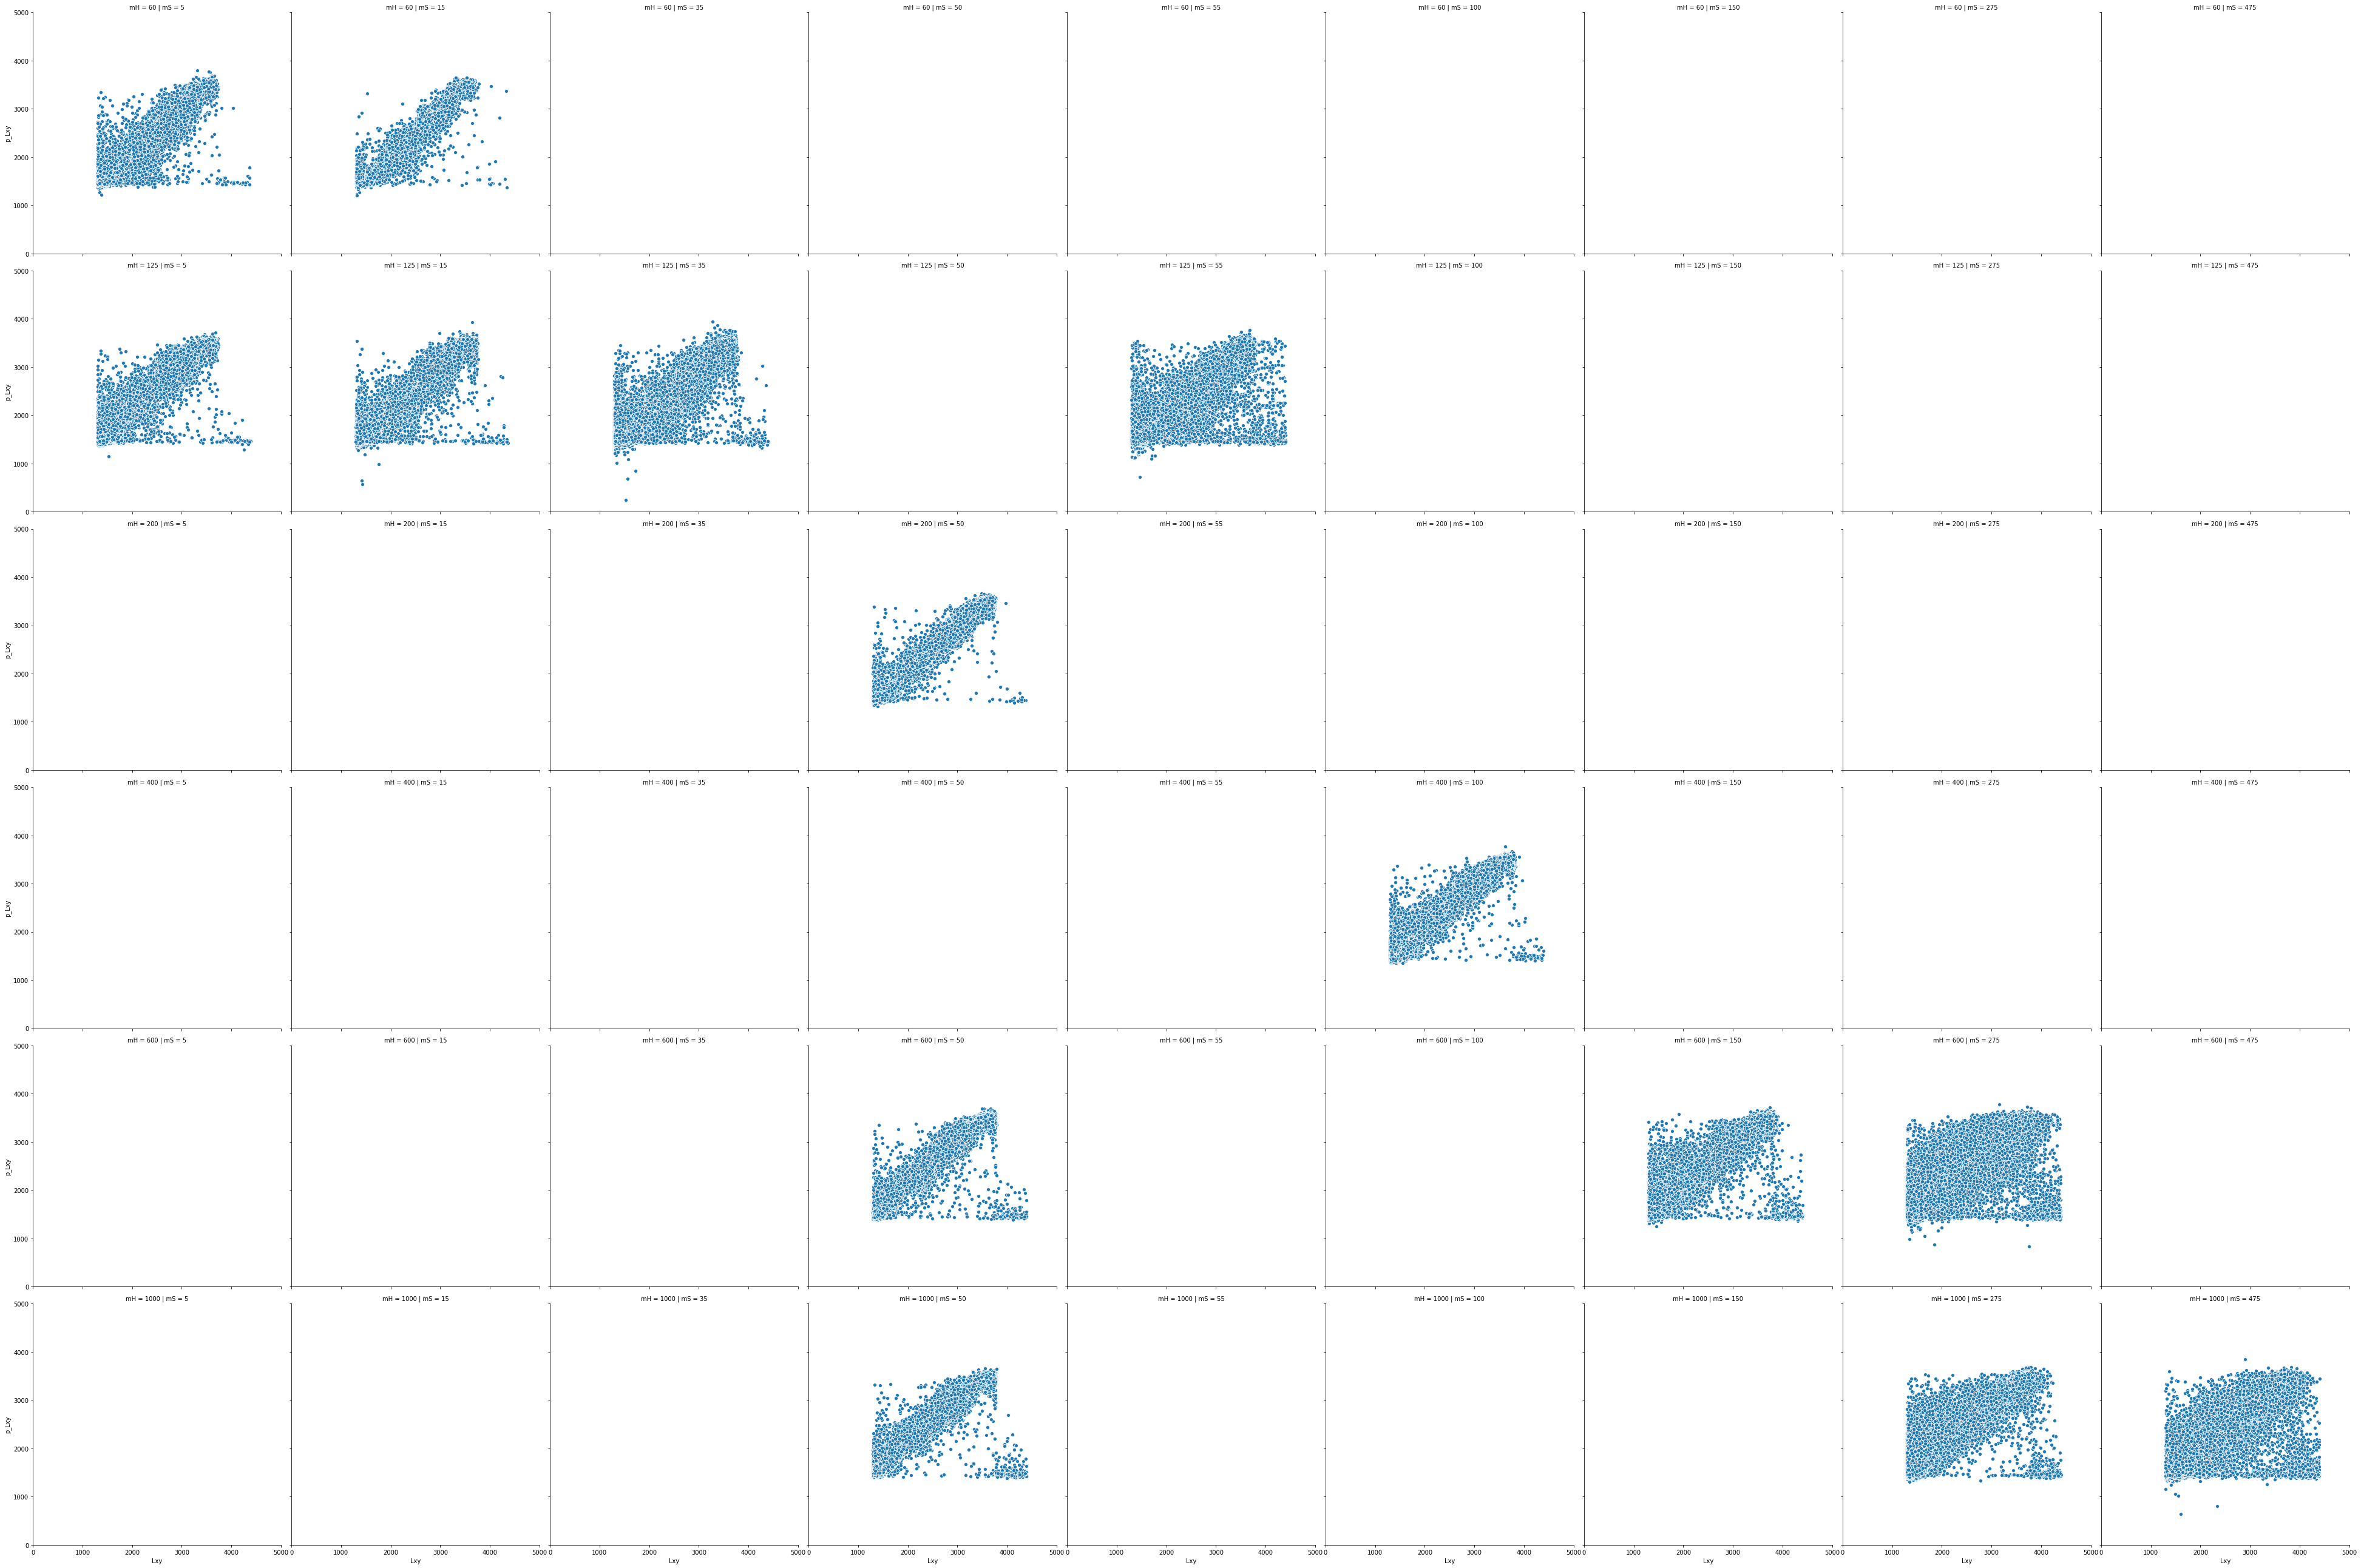

In [18]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', data=all_testing_jets, row='mH', col='mS', height=6, aspect=1)
mass_comparison.set(ylim=(0.0, 5000.0))
mass_comparison.set(xlim=(0.0, 5000.0))

In [19]:
what_to_train_on

['EMM_BL0',
 'EMM_BL1',
 'EMM_BL2',
 'EMM_BL3',
 'EMM_EL0',
 'EMM_EL1',
 'EMM_EL2',
 'EMM_EL3',
 'EH_EL0',
 'EH_EL1',
 'EH_EL2',
 'EH_CBL0',
 'EH_CBL1',
 'EH_CVL2',
 'EH_TGL0',
 'EH_TGL1',
 'EH_TGL2',
 'EH_EBL0',
 'EH_EBL1',
 'EH_EBL2',
 'JetPt',
 'JetEta']

## The Calorimeter Edge Effect

Looking at these plots there are many of them that have a seeming edge - a group of jets that have $L_{xy}$ that run along the calorimeter, but are all predicted to be at the face. My guess is this is connected with pileup somehow. So this is just an irreducable background.

First, lets isolate them.

In [20]:
all_testing_jets['EdgeBadReco'] = (all_testing_jets.p_Lxy < 1750) & (all_testing_jets.Lxy > 2500)

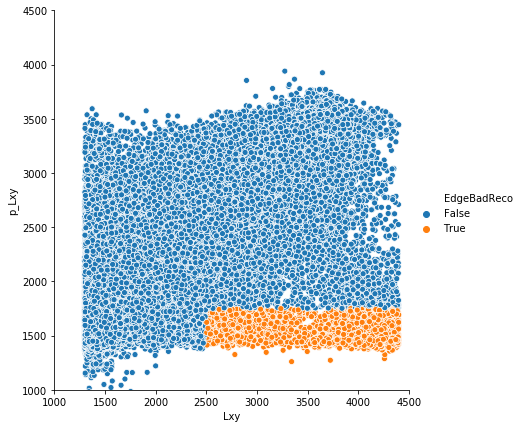

In [21]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', hue='EdgeBadReco', data=all_testing_jets, height=6, aspect=1)
mass_comparison.set(ylim=(1000.0, 4500.0))
mass_comparison.set(xlim=(1000.0, 4500.0))

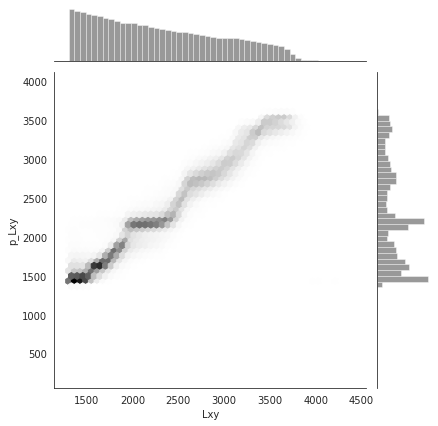

In [22]:
with sns.axes_style("white"):
    sns.jointplot(x='Lxy', y='p_Lxy', kind="hex", color="k", height=6, data=all_testing_jets)

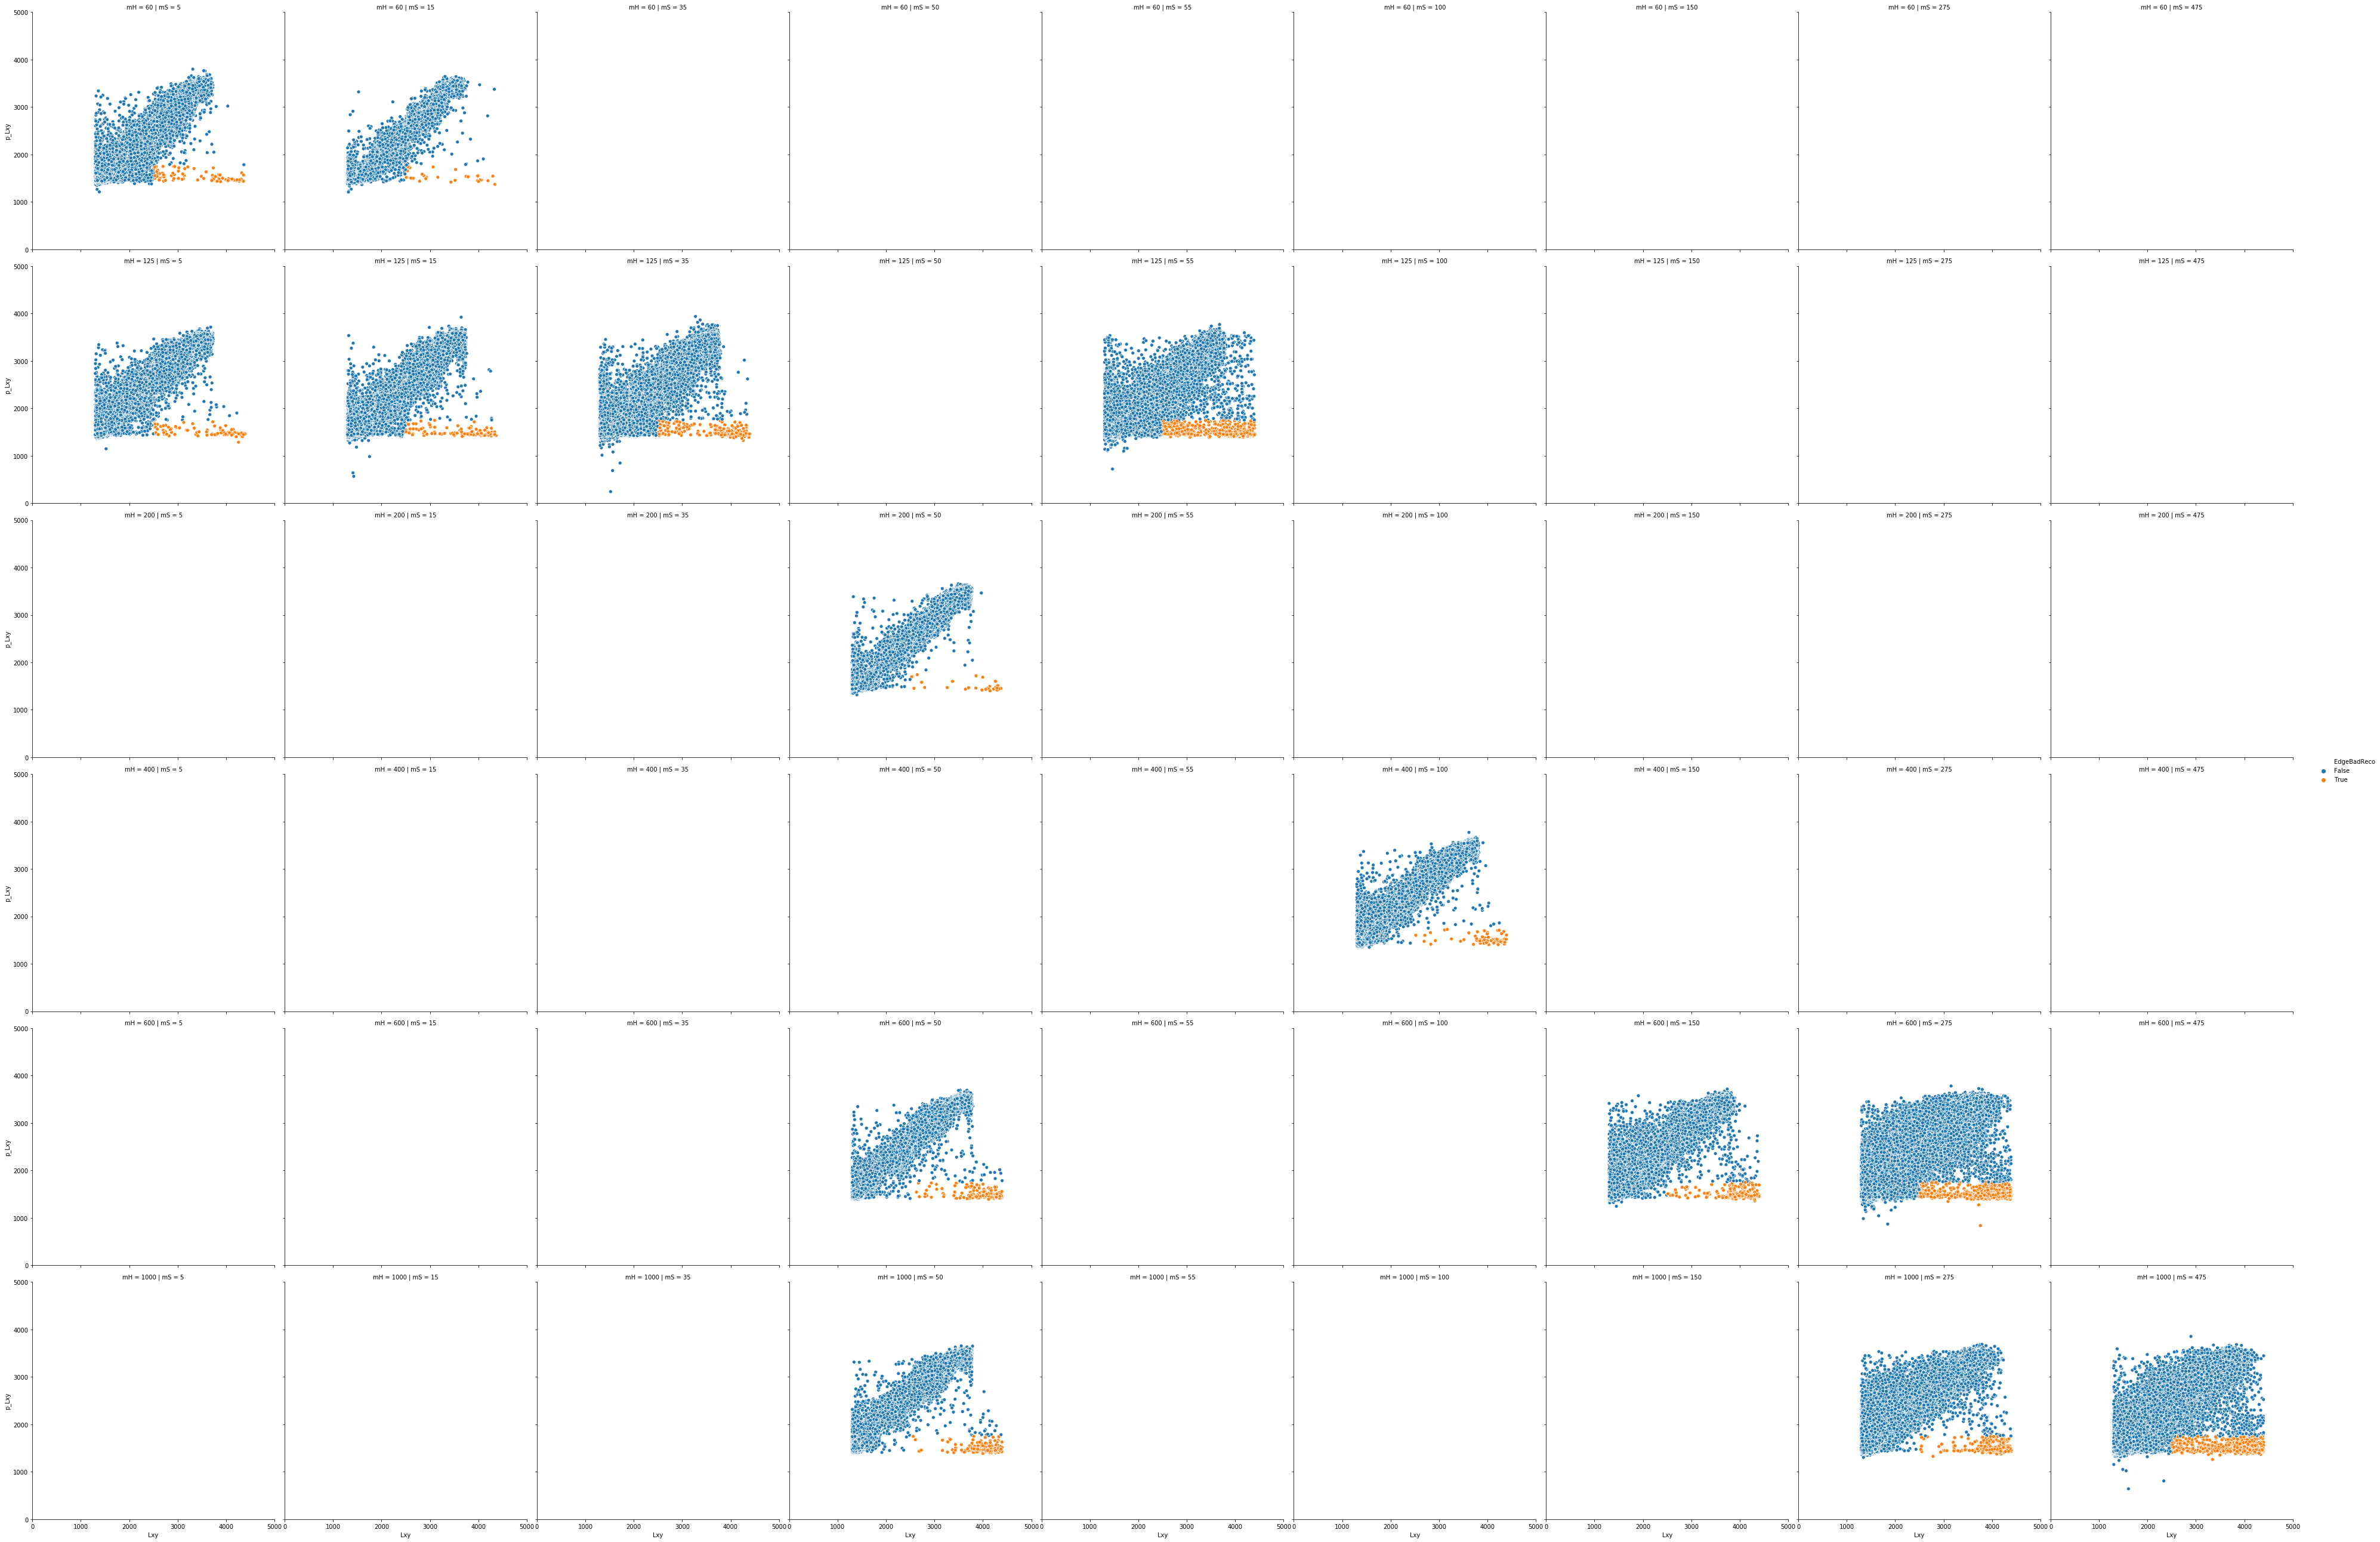

In [23]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', hue='EdgeBadReco', data=all_testing_jets, row='mH', col='mS', height=6, aspect=1)
mass_comparison.set(ylim=(0.0, 5000.0))
mass_comparison.set(xlim=(0.0, 5000.0))

### Kinematics?

Get an idea behind simple kinematics.

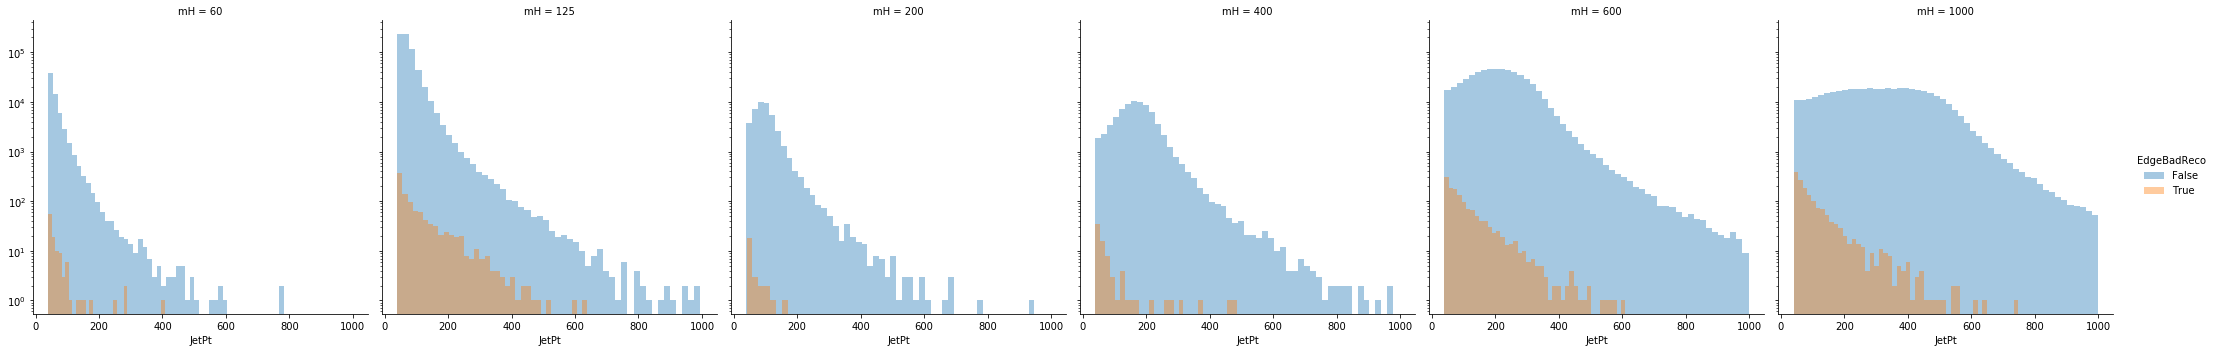

In [24]:
#sns.distplot(x='JetPt', hue='EdgeBadReco', data=all_testing_jets)
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'JetPt', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()

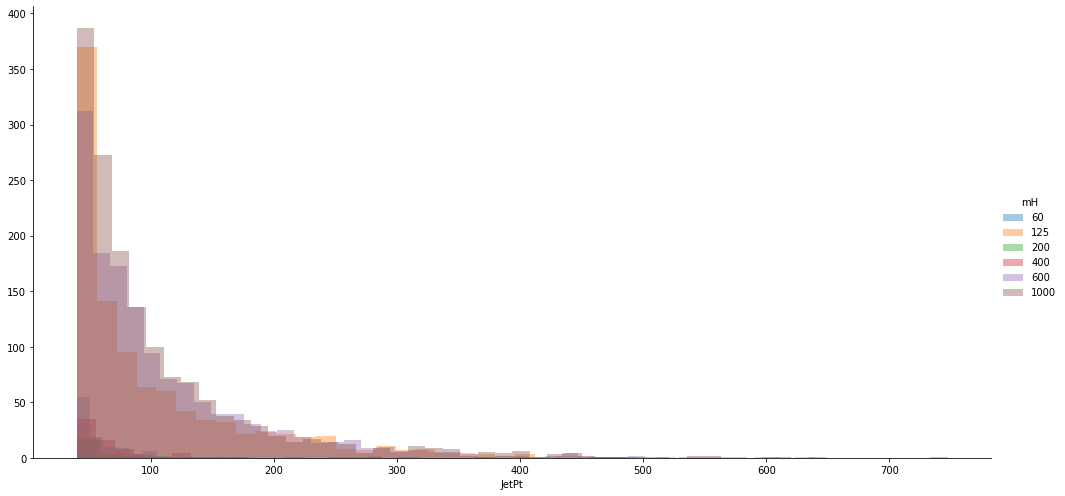

In [25]:
g = sns.FacetGrid(all_testing_jets[(all_testing_jets.JetPt < 1000) & (all_testing_jets.EdgeBadReco==True)], hue='mH', height=7, aspect=2)
g.map(sns.distplot, 'JetPt', norm_hist=False, kde=False)
g.add_legend()

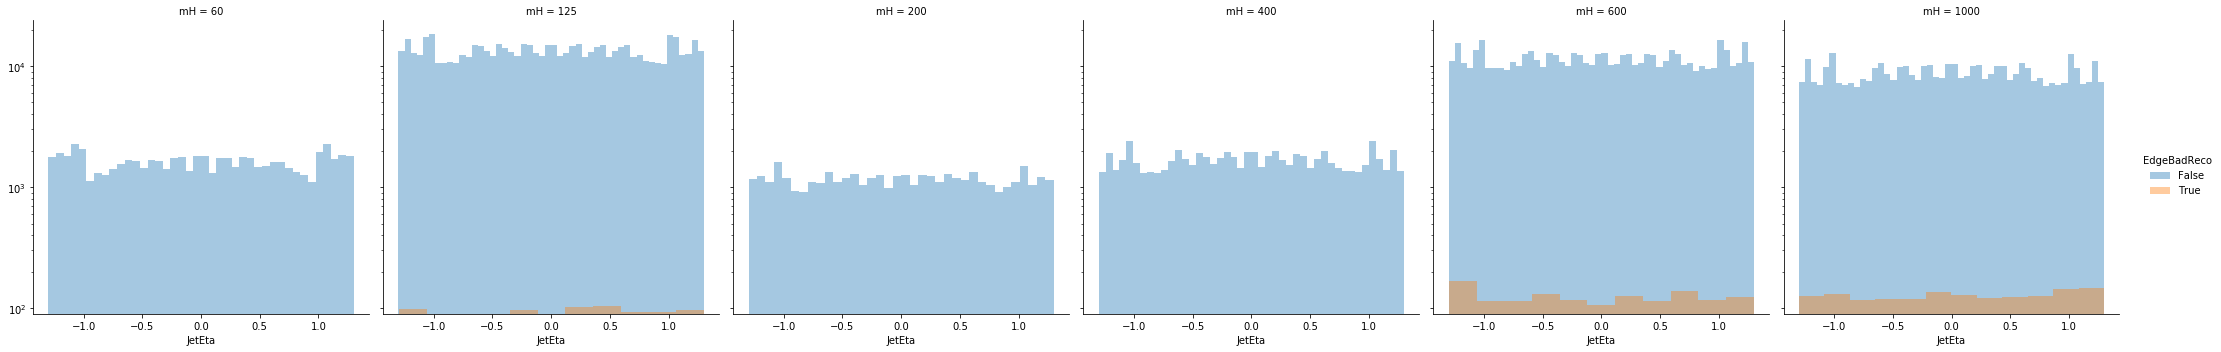

In [26]:
#sns.distplot(x='JetPt', hue='EdgeBadReco', data=all_testing_jets)
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'JetEta', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()

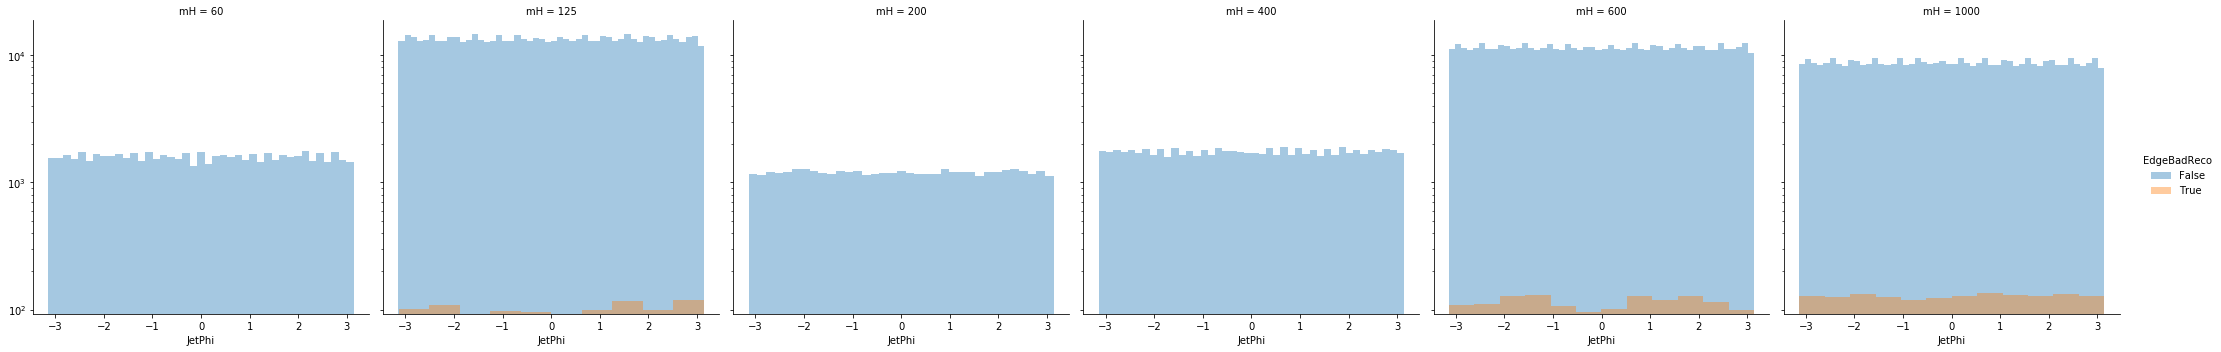

In [27]:
#sns.distplot(x='JetPt', hue='EdgeBadReco', data=all_testing_jets)
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'JetPhi', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()

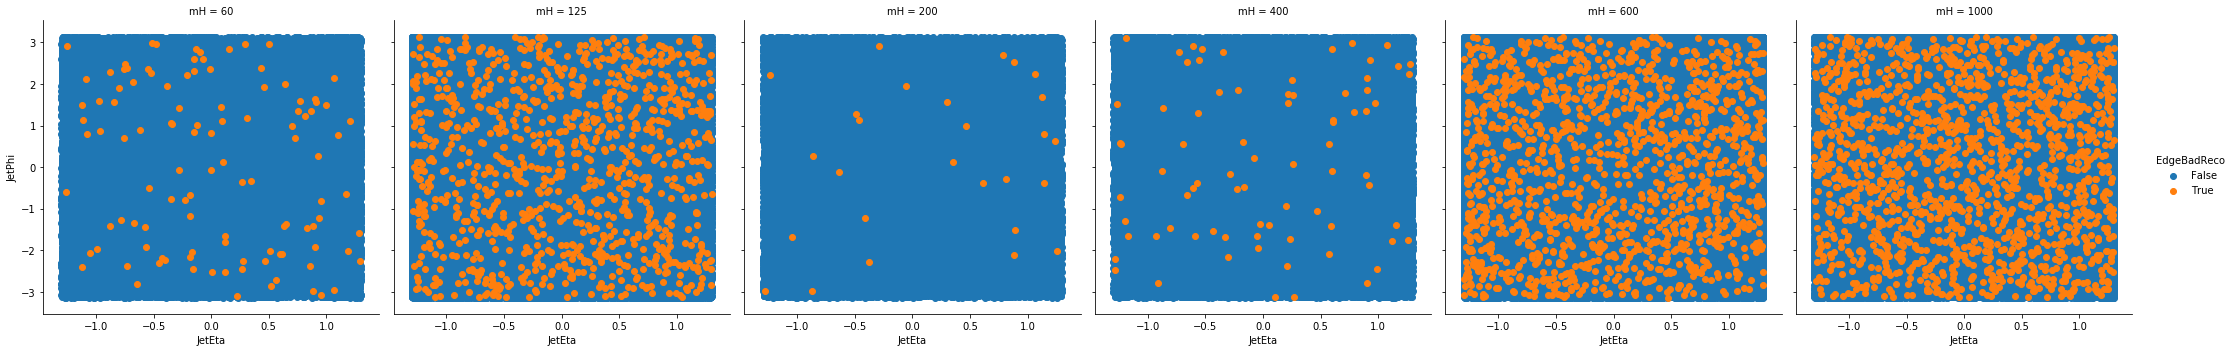

In [28]:
#sns.distplot(x='JetPt', hue='EdgeBadReco', data=all_testing_jets)
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(plt.scatter, 'JetEta', 'JetPhi')
g.add_legend()

Lets look at the inner layer of the EM. We know from the input variables plot that it is not really responding for an $L_{xy} > 1750$ mm. So that means that we should see little energy there. If there is another jet - like a pileup jet, then we should see an energy deposit there.

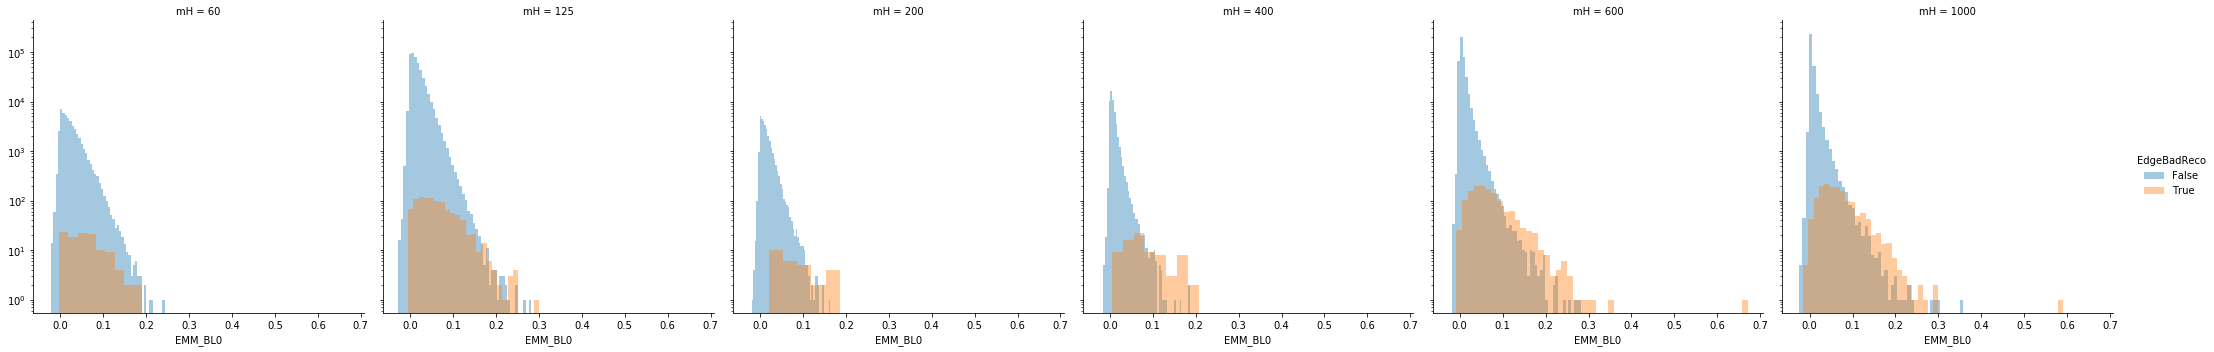

In [29]:
#sns.distplot(x='JetPt', hue='EdgeBadReco', data=all_testing_jets)
g = sns.FacetGrid(all_testing_jets[(all_testing_jets.JetPt < 1000) & (all_testing_jets.Lxy > 1750)], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'EMM_BL0', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()

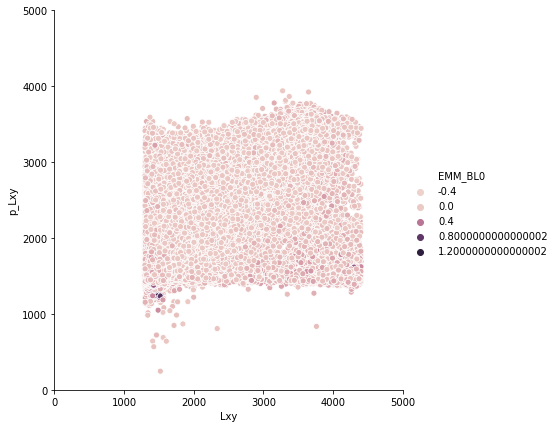

In [30]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', hue='EMM_BL0', data=all_testing_jets, height=6, aspect=1)
mass_comparison.set(ylim=(0.0, 5000.0))
mass_comparison.set(xlim=(0.0, 5000.0))

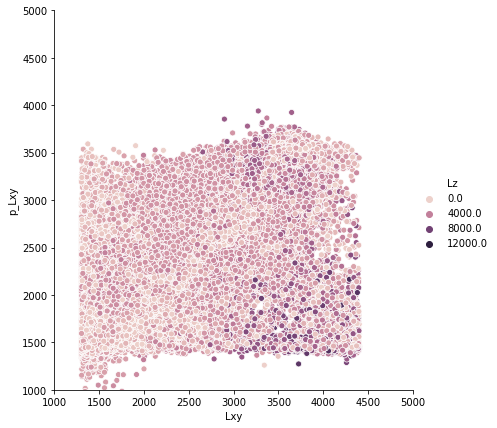

In [31]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', hue='Lz', data=all_testing_jets, height=6, aspect=1)
mass_comparison.set(ylim=(1000.0, 5000.0))
mass_comparison.set(xlim=(1000.0, 5000.0))

Some of these look like they have very very high $L_z$ values and also high $L_xy$ - which doesn't make sense from the POV of $|\eta|<1.3$ cut. Lets quickly look at a few of these.

In [32]:
all_testing_jets[(all_testing_jets.EdgeBadReco==True) & (all_testing_jets.Lz > 9000.0)].filter(items=['JetEta', 'Lxy', 'Lz'])

JetEta          Lxy            Lz
396460  -1.294429  4322.070104  10124.902344
553632   1.280970  4260.972479  10542.963867
561931   1.297409  3971.188820   9092.417969
652145  -1.238221  4112.263337   9520.717773
685591  -1.264343  4184.103232  10340.398438
696467  -1.226152  4001.449939   9284.493164
746509  -1.278901  4259.372254  10321.165039
864274  -1.258007  4135.763225   9415.487305
897729  -1.261613  3738.457474   9150.419922
1147304 -1.245345  3764.343294   9084.766602
1153921  1.278778  3997.979396   9282.050781
1191658 -1.258937  4384.682478  10595.430664
1227857  1.289506  4156.814376   9803.544922
1344114 -1.240175  4261.908206   9938.167969
1592772  1.273278  4253.962872   9306.698242
1669104  1.293136  3718.417806   9007.442383
1675203 -1.261961  4223.995271   9254.890625
1720606 -1.265232  4315.569718  10852.294922
1736061 -1.297070  3920.197973  10283.015625
1793831 -1.200441  4387.363197   9594.208008
1830625 -1.228313  4296.769242   9112.958008
1854878  1.264076  4057.448378   9172.896484

Hmmm... first of all - repeated events. That isn't good! Second, the error was looking at $p_L_{xy}$, not $L_{xy}$. Ok that makes lots more sense.

I admit to being a bit suprised. This 2D plot is inconclusive:

- On one hand, it the well reconstructed often has lower energy than this guy.
- But that isn't always the case!

We can definately conclude that EMM_BL0 is higher for these funny jets. But it isn't black & white.

Lets look at the difference in $p_T$ between the LLP and the jet.

In [33]:
all_testing_jets['DeltaMCPt'] = np.abs(all_testing_jets.JetPt - all_testing_jets.Lpt)/all_testing_jets.Lpt

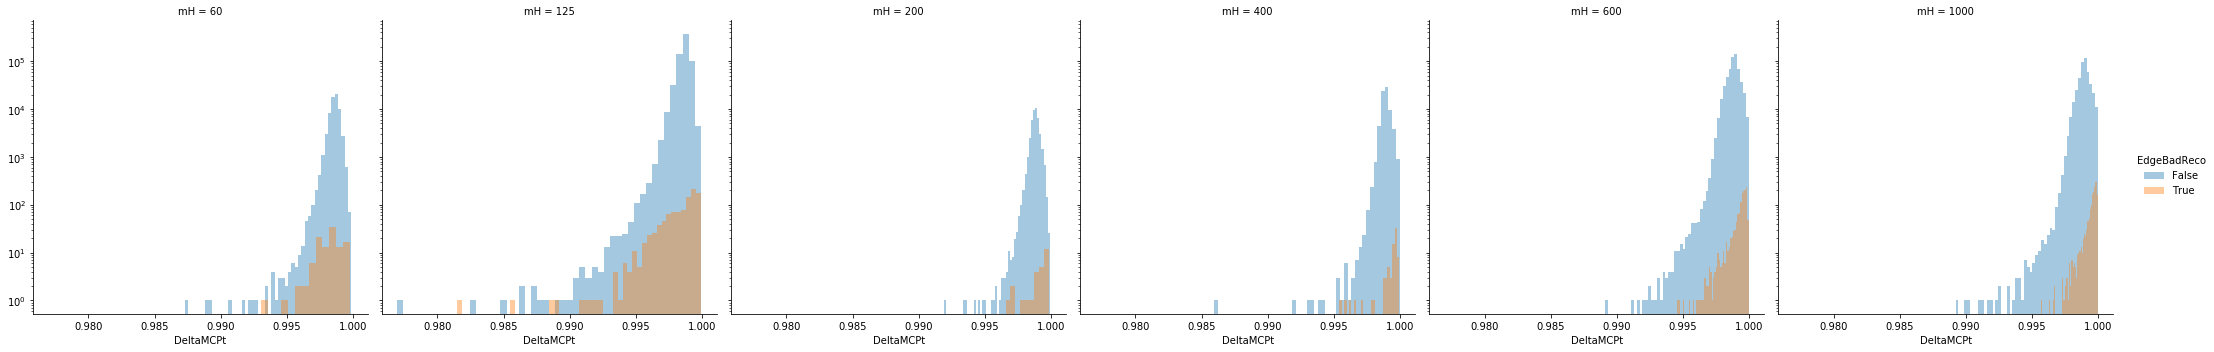

In [34]:
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'DeltaMCPt', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()

In [35]:
all_testing_jets['DeltaMCPtRaw'] = (all_testing_jets.JetPt - all_testing_jets.Lpt)/all_testing_jets.Lpt

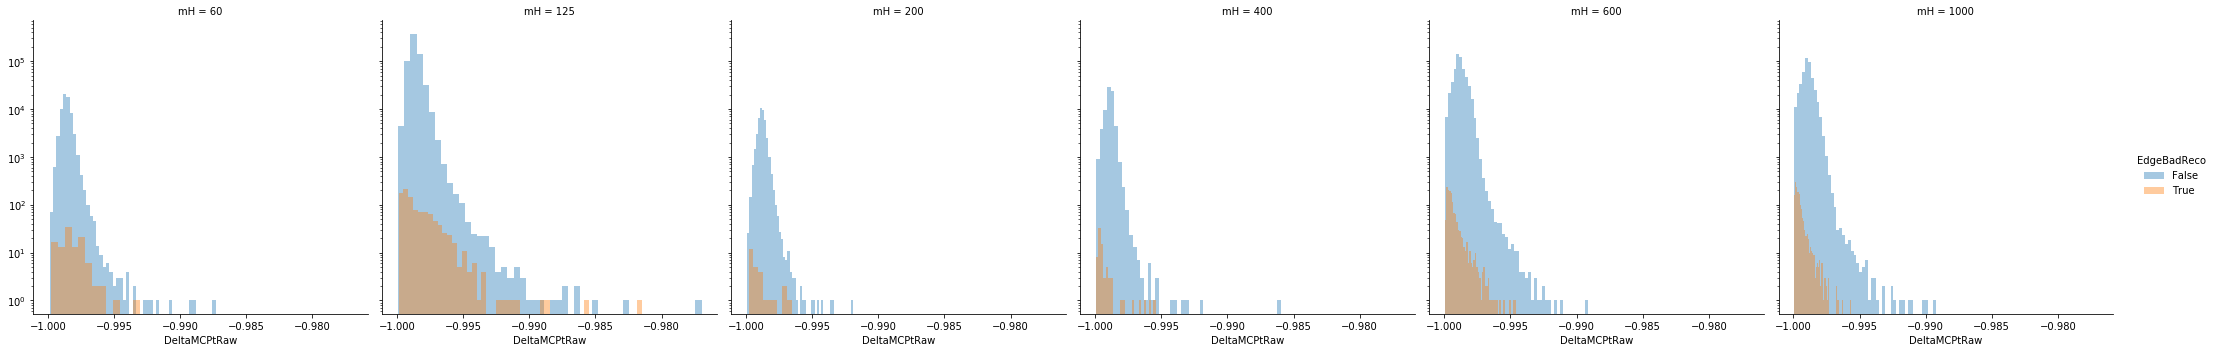

In [36]:
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'DeltaMCPtRaw', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()